## 1 ) Importing necessary libraries

In [1]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.228 🚀 Python-3.10.13 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete ✅ (16 CPUs, 15.8 GB RAM, 237.4/294.6 GB disk)


In [61]:
import numpy as np 
import pandas as pd 
import os
import math
import tensorflow as tf
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle           
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings("ignore")
import pickle

## 2 ) Ensure that the directory structure is correct

In [58]:
classification_directory = r'C:\Users\ehabe\Desktop\Dataset\classification'
train_classification = r'C:\Users\ehabe\Desktop\Dataset\classification\train_classification'
val_classification = r'C:\Users\ehabe\Desktop\Dataset\classification\val_classification'
detection_directory = r'C:\Users\ehabe\Desktop\Dataset\detection'
train_detection = r'C:\Users\ehabe\Desktop\Dataset\detection\train'
val_detection = r'C:\Users\ehabe\Desktop\Dataset\detection\val'
few_shot_learning_directory = r'C:\Users\ehabe\Desktop\Dataset\few-shot-learning'

# Task 1 ) Image Classification

### 1.1 ) Image File Reading and Organizing Training Dataset

In [6]:
import os
import shutil

base_directory = r'C:\Users\ehabe\Desktop\Dataset\classification\train'

images = []
labels = []
IMAGE_SIZE = (224, 224)
class_names = []
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
for subdirectory in os.listdir(base_directory):
    subdirectory_path = os.path.join(base_directory, subdirectory)
    class_names.append(subdirectory)
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


    if os.path.isdir(subdirectory_path):
        for index, image_file in enumerate(os.listdir(subdirectory_path)):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                original_path = os.path.join(subdirectory_path, image_file)
                image = cv2.imread(original_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                label = class_names_label[subdirectory]

                
                
                images.append(image)
                labels.append(label)



In [7]:

base_directory = r'C:\Users\ehabe\Desktop\Dataset\classification\val'


val_images = []
val_labels = []
IMAGE_SIZE = (224, 224)

nb_classes = len(class_names)
for subdirectory in os.listdir(base_directory):
    subdirectory_path = os.path.join(base_directory, subdirectory)


    if os.path.isdir(subdirectory_path):
        for index, image_file in enumerate(os.listdir(subdirectory_path)):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):

                original_path = os.path.join(subdirectory_path, image_file)
                image = cv2.imread(original_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                label = class_names_label[subdirectory]

                
                
                val_images.append(image)
                val_labels.append(label)



### 1.1 ) Contrast Limited Adaptive Histogram Equalization (CLAHE)

As we know the dataset contains lighting variations so we will use (CLAHE).CLAHE is an image processing technique used to enhance the contrast in images, especially in regions where the contrast is poor. Traditional histogram equalization stretches the intensity values across the entire image, which can lead to over-amplification of noise and undesirable artifacts.

In [8]:
def pop_clache(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    enhanced_lab = cv2.merge([cl, a, b])

    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

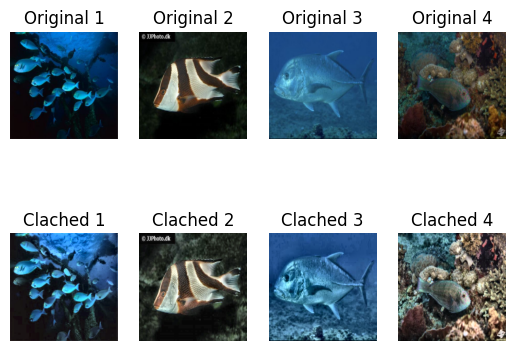

In [9]:
num_examples = 4

for i in range(num_examples):
    original_image = images[i]
    
    clached_image = pop_clache(original_image)

    plt.subplot(2, num_examples, i + 1)
    plt.imshow(original_image)
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(clached_image)
    plt.title(f'Clached {i + 1}')
    plt.axis('off')

plt.show()

In [10]:
enhanced_images = [pop_clache(image) for image in images]
val_enhanced_images = [pop_clache(image) for image in val_images]

### 1.2 ) Convert Images And Its Labels To Numby Array And Shuffle It

In [11]:
enhanced_images = np.array(enhanced_images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')   

In [12]:
val_enhanced_images = np.array(val_enhanced_images, dtype = 'float32')
val_labels = np.array(val_labels, dtype = 'int32')   

In [13]:
train_images, train_labels = shuffle(enhanced_images, labels, random_state=40)

In [14]:
val_images, val_labels = shuffle(val_enhanced_images, val_labels, random_state=40)

In [15]:
n_train = train_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1162
Each image is of size: (224, 224)


In [16]:
n_val = val_labels.shape[0]

print ("Number of Validation examples: {}".format(n_val))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of Validation examples: 308
Each image is of size: (224, 224)


### 1.2 ) Explore Clases Balance And Augmentation

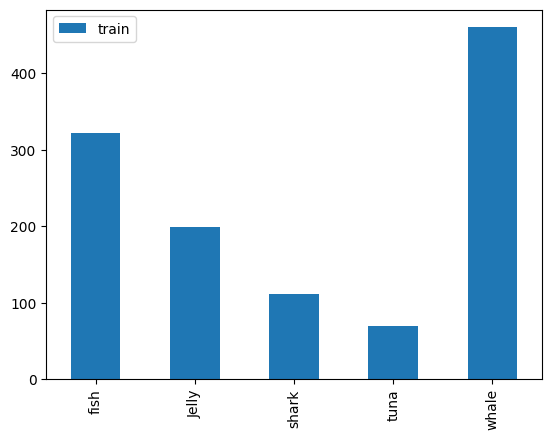

In [17]:
_, train_counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({'train': train_counts,}, 
             index=class_names
            ).plot.bar()
plt.show()

In [18]:
train_counts

array([322, 199, 111,  70, 460], dtype=int64)

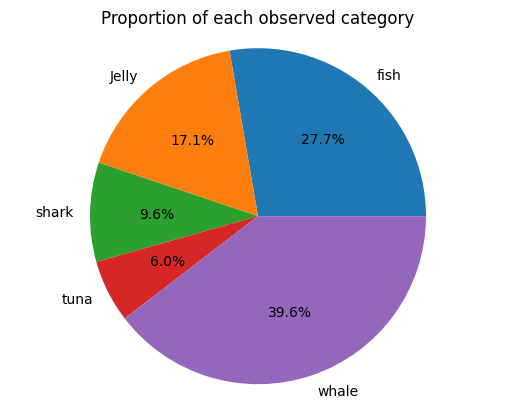

In [19]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

The dataset exhibits an imbalanced class distribution across five distinct categories:

1. **Whale**: Representing the majority, this cls asrepresentses 39.6% of the datas for 460 roet.
2. **Fish**: Following closely, the fish ss clarepresentsnts for 27 for 322 ro2s w7%.
3. **Jelly**: Comprising a substantial portion, the jellass representsesr ved  for 199 rows 7.1%.
4. **Shark**: With a comparatively lower occurrence, the shark class represents for 111 rows  9.6%.
5. **Tuna**: Occurring the least frequently, therepresentses fed e vor 70 rows t 6.0%.

This imbalanced distribution may have implications for model training and performance evaluation.balanced distribution may have implications for model training and performance evaluation.


In [20]:
target_samples = 460 

augmented_images = []
augmented_labels = []

In [21]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [22]:
for class_label in range(5): 
    class_indices = np.where(train_labels == class_label)[0]
    class_images = train_images[class_indices]
    class_labels = train_labels[class_indices]

    augmentation_factor = target_samples - len(class_images)

    for i in range(augmentation_factor):
        p=i%len(class_images)
        image = class_images
        augmented_batch = datagen.flow(image, batch_size=1)
        augmented_image = augmented_batch[0][0]
        augmented_images.append(augmented_image)
        augmented_labels.append(class_labels[p])


In [23]:
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

balanced_train_images = np.concatenate((train_images, augmented_images))
balanced_train_labels = np.concatenate((train_labels, augmented_labels))


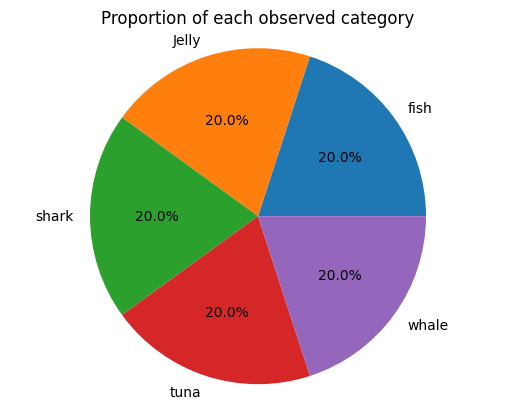

In [24]:
_, train_counts = np.unique(balanced_train_labels, return_counts=True)
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

### 1.3 ) Scale The Data And Visualize It

In [25]:
balanced_train_images = balanced_train_images / 255.0 
val_images = val_images / 255.0 
train_images, train_labels = shuffle(balanced_train_images, balanced_train_labels, random_state=25)

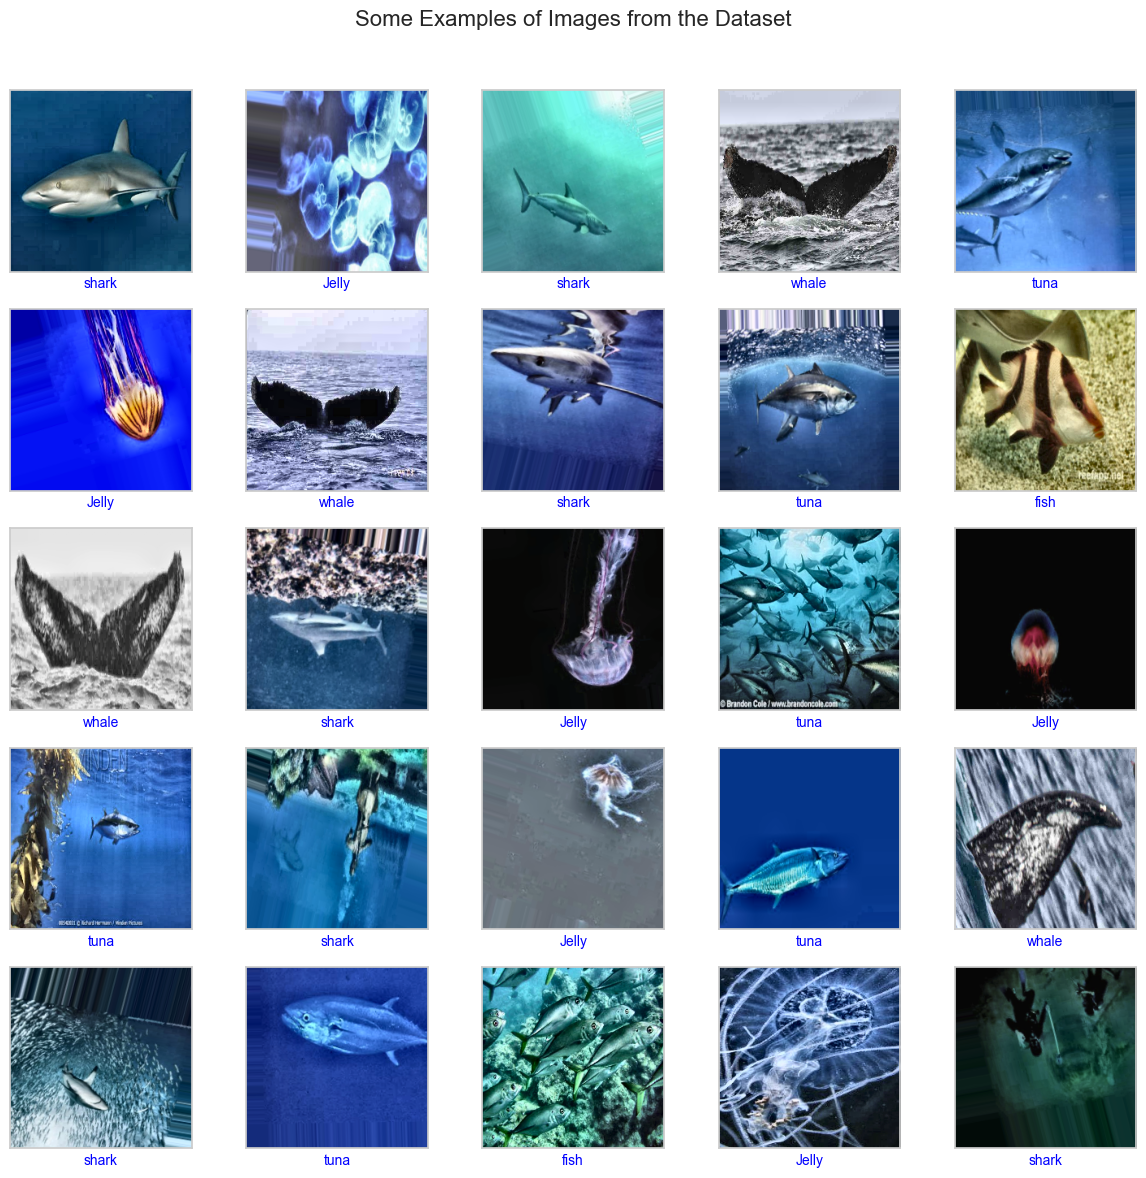

In [26]:
# Set a seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a figure
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle("Some Examples of Images from the Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(class_names[train_labels[i]], fontsize=10, color='blue')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 1.4 ) Saving Data Sets In New Directories

In [27]:
import os
import numpy as np
from PIL import Image

output_directory = train_classification

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for i, (image, label) in enumerate(zip(train_images, train_labels)):
    image = (image * 255).astype(np.uint8)
    
    pil_image = Image.fromarray(image)

    image_filename = f'{class_names[label]} {i + 1}.png'
    direc_path = os.path.join(output_directory, class_names[label])
    if not os.path.exists(direc_path):
        os.makedirs(direc_path)
    image_path = os.path.join(direc_path,image_filename)
    pil_image.save(image_path)

print(f"Images saved to: {output_directory}")


Images saved to: C:\Users\ehabe\Desktop\Dataset\classification\train_classification


In [28]:
import os
import numpy as np
from PIL import Image

output_directory = val_classification

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
for i, (image, label) in enumerate(zip(val_images, val_labels)):
    image = (image * 255).astype(np.uint8)
    
    pil_image = Image.fromarray(image)
    expected_shape = (224, 224, 3)
    image_filename = f'{class_names[label]} {i + 1}.png'
    direc_path = os.path.join(output_directory, class_names[label])
    if not os.path.exists(direc_path):
        os.makedirs(direc_path)
    image_path = os.path.join(direc_path,image_filename)
    pil_image.save(image_path)


print(f"Images saved to: {output_directory}")


Images saved to: C:\Users\ehabe\Desktop\Dataset\classification\val_classification


### 1.5 ) Create Data Loaders

In [29]:
batch_size = 20
image_size = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_classification,
    seed=45,
    shuffle=True,
    image_size=(224,224),
    batch_size=20
)



Found 2300 files belonging to 5 classes.


In [30]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_classification,
    seed=45,
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size
)

Found 308 files belonging to 5 classes.


In [31]:
# num_batches = len(train_generator)
# # Assuming train_generator is an instance of ImageDataGenerator.flow_from_directory
# batch_shape = (train_generator.batch_size,) + train_generator.image_shape

# print("Batch shape:", batch_shape)
# print("Number of batches:", num_batches)


### 1.6 ) Loading the Base Model For Transfer Learning

using a pre-trained model (transfer learning) is advantageous, as it allows leveraging knowledge learned from large datasets on tasks with smaller datasets.



In [32]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')


The VGG-16 is one of the most popular pre-trained models for image classification. Introduced in the famous ILSVRC 2014 Conference, it was and remains THE model to beat even today. Developed at the Visual Graphics Group at the University of Oxford, VGG-16 beat the then standard of AlexNet and was quickly adopted by researchers and the industry for their image Classification Tasks.

Here is the architecture of VGG-16:



<img src="C:\Users\ehabe\Downloads\vgg16-neural-network.jpg" width="800" height="400">

<img src="C:\Users\ehabe\Pictures\Screenshots\Screenshot (50).png" width="800" height="400">

### 1.7 ) Model Compile and Fit

In [33]:

x = Flatten()(base_model.output)

x = Dense(256, activation='LeakyReLU')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='LeakyReLU')(x)

x = Dropout(0.5)(x)


num_classes = 5
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [35]:
history = model.fit(
    train_data,               
    epochs=50,                
    batch_size=20,    
    validation_data=val_data, 
    callbacks=[early_stopping] 
)

Epoch 1/50
115/115 [==============================] - 14s 96ms/step - loss: 6.6291 - accuracy: 0.6326 - val_loss: 0.8645 - val_accuracy: 0.9221
Epoch 2/50
115/115 [==============================] - 10s 87ms/step - loss: 2.8492 - accuracy: 0.8187 - val_loss: 0.9300 - val_accuracy: 0.9156
Epoch 3/50
115/115 [==============================] - 10s 88ms/step - loss: 1.6677 - accuracy: 0.8804 - val_loss: 0.9727 - val_accuracy: 0.9481
Epoch 4/50
115/115 [==============================] - 10s 88ms/step - loss: 1.0397 - accuracy: 0.9196 - val_loss: 1.4303 - val_accuracy: 0.9481
Epoch 5/50
115/115 [==============================] - 10s 88ms/step - loss: 0.8386 - accuracy: 0.9374 - val_loss: 1.4036 - val_accuracy: 0.9416
Epoch 6/50
115/115 [==============================] - 10s 88ms/step - loss: 0.8614 - accuracy: 0.9465 - val_loss: 1.6418 - val_accuracy: 0.9383
Epoch 7/50
115/115 [==============================] - 10s 88ms/step - loss: 0.7443 - accuracy: 0.9491 - val_loss: 1.5014 - val_accuracy:

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

### 1.8 ) Save The model

In [37]:
with open('model.pkl', 'wb') as file:
    pickle.dump(history, file)

INFO:tensorflow:Assets written to: ram://45a60085-5ff2-4c2d-9dbf-a8b6158b14da/assets


INFO:tensorflow:Assets written to: ram://45a60085-5ff2-4c2d-9dbf-a8b6158b14da/assets


### 1.9 ) Evaluate the Model

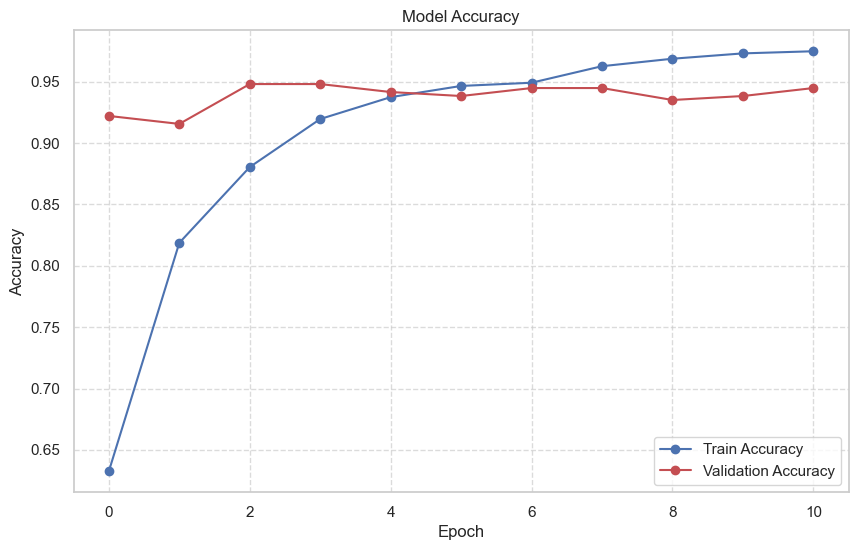

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', color='r', label='Validation Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [56]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf

def test_script(base_directory, class_names, class_names_label, model, batch_size=32):
    test_classification = r"C:\Users\ehabe\Desktop\test_classification"
    test_images = []
    test_labels = []
    IMAGE_SIZE = (224, 224)

    nb_classes = len(class_names)
    for subdirectory in os.listdir(base_directory):
        subdirectory_path = os.path.join(base_directory, subdirectory)

        if os.path.isdir(subdirectory_path):
            for index, image_file in enumerate(os.listdir(subdirectory_path)):
                if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                    original_path = os.path.join(subdirectory_path, image_file)
                    image = cv2.imread(original_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE)
                    label = class_names_label[subdirectory]

                    test_images.append(image)
                    test_labels.append(label)

    # Applying CLAHE
    test_enhanced_images = [pop_clache(image) for image in test_images]

    # Convert Images And Its Labels To NumPy Array And Shuffle It
    test_enhanced_images = np.array(test_enhanced_images, dtype='float32')
    test_labels = np.array(test_labels, dtype='int32')
    test_images, test_labels = shuffle(test_enhanced_images, test_labels, random_state=40)

    # Normalization
    test_images = test_images / 255.0

    # Saving in a new directory
    output_directory = test_classification

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    correct_predictions = 0
    total_samples = len(test_labels)

    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        image = (image * 255).astype(np.uint8)
        pil_image = Image.fromarray(image)
        expected_shape = (224, 224, 3)
        image_filename = f'{class_names[label]}_{i + 1}.png'  # Changed filename format
        direc_path = os.path.join(output_directory, class_names[label])
        if not os.path.exists(direc_path):
            os.makedirs(direc_path)
        image_path = os.path.join(direc_path, image_filename)
        pil_image.save(image_path)

    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_classification,
        seed=45,
        shuffle=False,
        image_size=IMAGE_SIZE,
        batch_size=batch_size
    )

    predictions = model.predict(test_data)

    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        predicted_label = np.argmax(predictions[i])
        print(f"Image: {class_names[label]}_{i + 1}.png, True Label: {class_names[label]}, "
              f"Predicted Label: {class_names[predicted_label]}")

        # Check if the prediction is correct
        if predicted_label == label:
            correct_predictions += 1


# Example usage
directory = r"C:\Users\ehabe\Desktop\test"
test_script(directory, class_names, class_names_label,model, batch_size=32)

Found 332 files belonging to 5 classes.
11/11 [==============================] - 1s 115ms/step
Image: fish_1.png, True Label: fish, Predicted Label: fish
Image: whale_2.png, True Label: whale, Predicted Label: whale
Image: tuna_3.png, True Label: tuna, Predicted Label: tuna
Image: fish_4.png, True Label: fish, Predicted Label: fish
Image: fish_5.png, True Label: fish, Predicted Label: fish
Image: fish_6.png, True Label: fish, Predicted Label: fish
Image: fish_7.png, True Label: fish, Predicted Label: fish
Image: shark_8.png, True Label: shark, Predicted Label: shark
Image: shark_9.png, True Label: shark, Predicted Label: shark
Image: fish_10.png, True Label: fish, Predicted Label: fish
Image: whale_11.png, True Label: whale, Predicted Label: whale
Image: tuna_12.png, True Label: tuna, Predicted Label: tuna
Image: fish_13.png, True Label: fish, Predicted Label: fish
Image: shark_14.png, True Label: shark, Predicted Label: shark
Image: shark_15.png, True Label: shark, Predicted Label: sh

# Task 2 ) Object detection

### 2.1 ) Image File Reading and Organizing Training Dataset

In [62]:
train_images = {}  
train_directory = r'C:\Users\ehabe\Desktop\Dataset\detection\train'
train_csv = pd.DataFrame()

for subdirectory in os.listdir(train_directory):
    subdirectory_path = os.path.join(train_directory, subdirectory)
    
    if os.path.isdir(subdirectory_path):
        for index, file in enumerate(os.listdir(subdirectory_path)):
            if file.lower().endswith(".txt"):  
                annotation_file_path = os.path.join(subdirectory_path, file)
                
                annotations = pd.read_csv(annotation_file_path, header=None, names=['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax'])
                file_name = os.path.splitext(file)[0]

                annotations['ID'] = file_name+'.jpg'
                annotations['Class'] = subdirectory
                
                train_csv = pd.concat([train_csv, annotations], ignore_index=True)
            
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_path = os.path.join(subdirectory_path, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                train_images[file] = image


In [63]:
train_csv.shape

(1832, 8)

In [64]:
val_images = {}  
val_directory = r'C:\Users\ehabe\Desktop\Dataset\detection\val'
val_csv = pd.DataFrame()

for subdirectory in os.listdir(val_directory):
    subdirectory_path = os.path.join(val_directory, subdirectory)
    
    if os.path.isdir(subdirectory_path):
        for index, file in enumerate(os.listdir(subdirectory_path)):
            if file.lower().endswith(".txt"):  
                annotation_file_path = os.path.join(subdirectory_path, file)
                
                annotations = pd.read_csv(annotation_file_path, header=None, names=['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax'])
                file_name = os.path.splitext(file)[0]

                annotations['ID'] = file_name+'.jpg'
                annotations['Class'] = subdirectory
                
                val_csv = pd.concat([val_csv, annotations], ignore_index=True)
            
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_path = os.path.join(subdirectory_path, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                val_images[file] = image


In [65]:
val_csv.shape

(374, 8)

### 2.2 ) Classes visualization

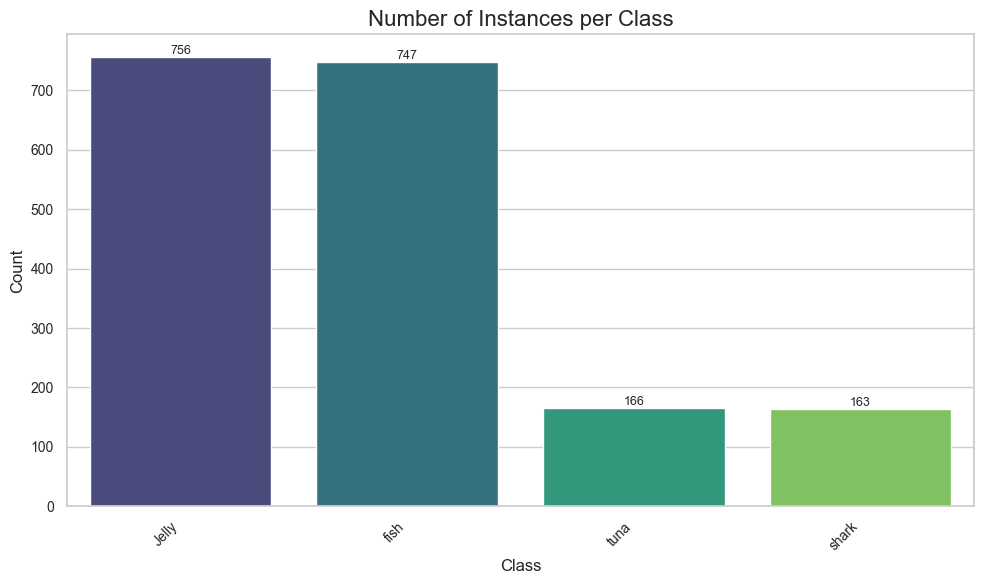

In [66]:
class_counts = train_csv['Class'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Instances per Class', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for index, value in enumerate(class_counts['Count']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 2.3 ) Reformat the data to yolov7 input shape

YOLOv7 expects annotations for each image in form of a .txt file where each line of the text file describes a bounding box. Consider the following image.



<img src="C:\Users\ehabe\Downloads\image-25.png">

The annotation file for the image contains the coordinates for each of the bounding boxes shown above. The format of these labels will look like the following:



<img src="C:\Users\ehabe\Downloads\image-26.png">

As we can see, there are 3 objects in total (2 persons and one tie). Each line represents one of these objects. The specification for each line is as follows.

- `One row per object`
- `The columns are class, x_center, y_center, width, and height format.`
- `These box coordinates must be normalized to the dimensions of the image (i.e. have values between 0 and 1)`
- `Class numbers are zero-indexed (start from 0).`

We will compute the x_center and y_center coordinates for each bounding box, and subsequently normalize the image dimensions. Additionally, we will encode the class labels with numerical values.

In [67]:
train_csv['x_center'] = (train_csv['xmin'] + train_csv['xmax']) / 2
train_csv['y_center'] = (train_csv['ymin'] + train_csv['ymax']) / 2
train_csv['boundry_width'] = (train_csv['xmax'] - train_csv['xmin']) 
train_csv['boundry_height'] = (train_csv['ymax'] - train_csv['ymin']) 

new_order = ['ID', 'Class', 'x_center', 'y_center', 'boundry_width', 'boundry_height', 'xmin', 'ymin', 'xmax', 'ymax','width','height']
train_csv = train_csv[new_order]



In [68]:
val_csv['x_center'] = (val_csv['xmin'] + val_csv['xmax'])/2
val_csv['y_center'] = (val_csv['ymin'] + val_csv['ymax']) /2
val_csv['boundry_width'] = (val_csv['xmax'] - val_csv['xmin']) 
val_csv['boundry_height'] = (val_csv['ymax'] - val_csv['ymin']) 

val_csv = val_csv[new_order]


### 2.4 ) Encode The CLasses

In [69]:
class_names = train_csv['Class'].unique().tolist()
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
label_class_name  =  {i:class_name for i, class_name in enumerate(class_names)}

In [70]:
train_csv['Class'] = train_csv['Class'].map(class_names_label)

In [71]:
val_csv['Class'] = val_csv['Class'].map(class_names_label)


### 2.5 ) Rezize The Images & Annonations

In [72]:
avg_width = math.ceil(train_csv['height'].mean())

print(f"Average Width: {avg_width}")


Average Width: 517


In [73]:
avg_height = math.ceil(train_csv['height'].mean())

print(f"Average Height: {avg_height}")


Average Height: 517


In [74]:
def resize_images(train_images, IMAGE_SIZE):
    resized_images = {}

    for file_name, image in train_images.items():
        resized_image = cv2.resize(image, IMAGE_SIZE)
        resized_images[file_name] = resized_image

    return resized_images

IMAGE_SIZE = (544, 544)

# Resize the images
train_images = resize_images(train_images, IMAGE_SIZE)
val_images = resize_images(val_images, IMAGE_SIZE)

In [75]:
def scale_and_transform(row):
    x_scale = IMAGE_SIZE[0] / row['width']  
    y_scale = IMAGE_SIZE[1] / row['height'] 

    row['x_center'] = row['x_center'] * x_scale
    row['y_center'] = row['y_center'] * y_scale
    row['boundry_width'] = row['boundry_width'] * x_scale
    row['boundry_height'] = row['boundry_height'] * y_scale
    row['xmin'] = row['xmin'] * x_scale
    row['ymin'] = row['ymin'] * y_scale
    row['xmax'] = row['xmax'] * x_scale
    row['ymax'] = row['ymax'] * y_scale
    row['width'] =IMAGE_SIZE[0]
    row['height'] = IMAGE_SIZE[1] 

    return row


In [76]:
train_csv = train_csv.apply(scale_and_transform, axis=1)
val_csv = val_csv.apply(scale_and_transform, axis=1)


### 2.6 ) Vizualize The Images & Annonations

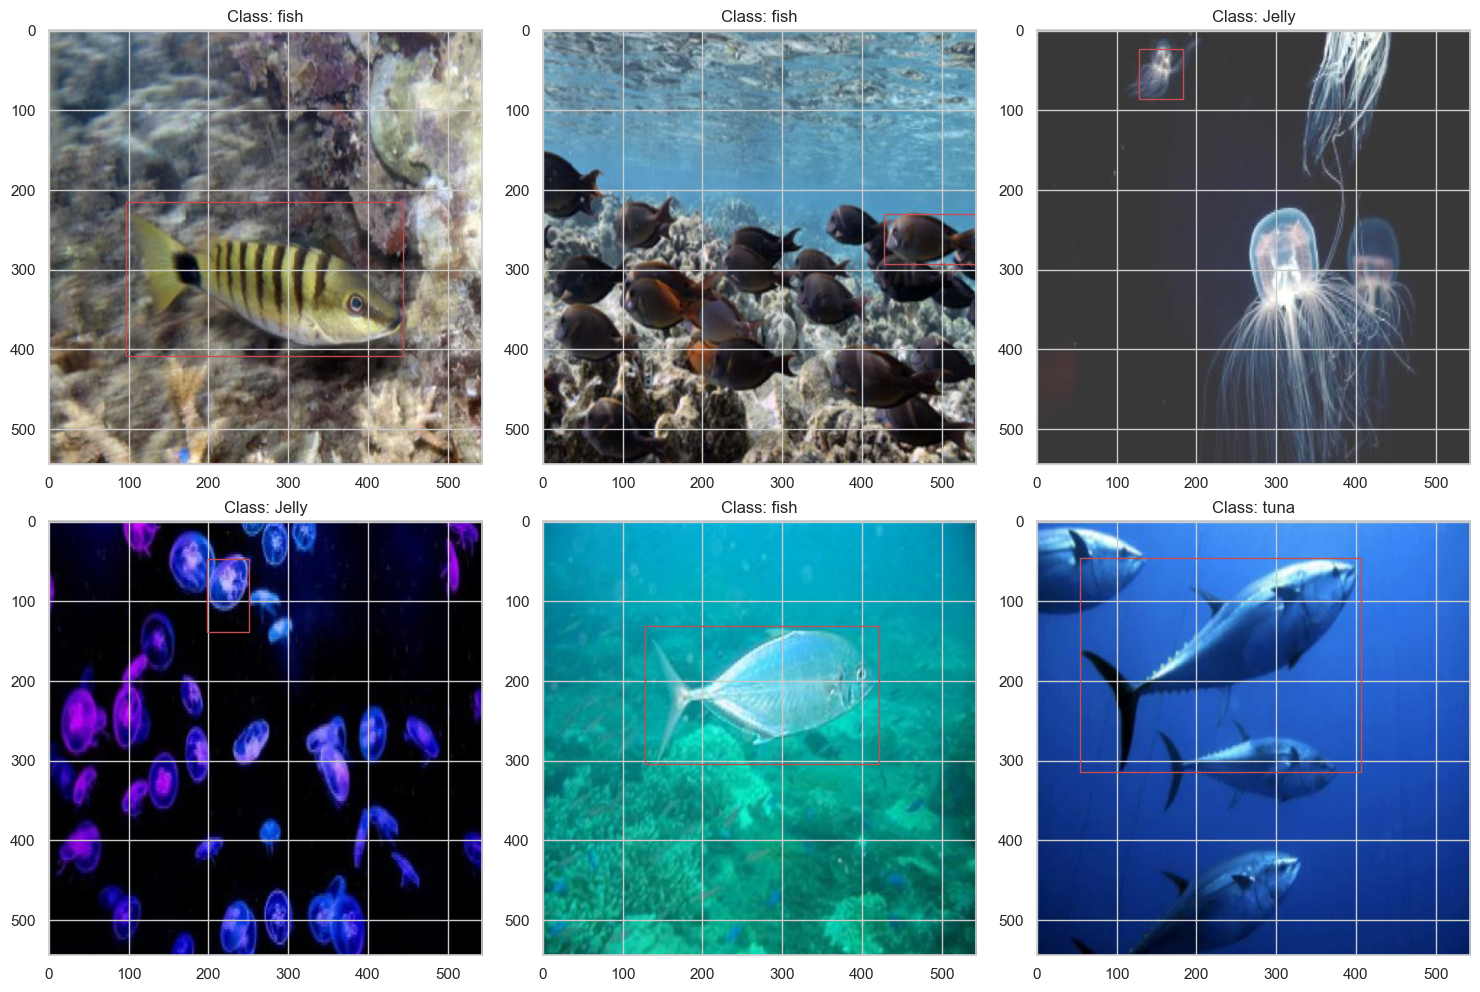

In [77]:
def visualize_random_images_with_boxes(train_csv, train_images, num_images_per_row, num_rows):
    num_rows_in_csv = len(train_csv)

    indices_to_visualize = random.sample(range(num_rows_in_csv), num_images_per_row * num_rows)

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, 5*num_rows))
    
    axs = axs.flatten()

    for i, index in enumerate(indices_to_visualize):
        row = train_csv.iloc[index]

        file_name = row['ID']
        image = train_images.get(file_name)

        if image is not None:
            x = row['xmin']
            y = row['ymin']
            width = row['boundry_width']
            height = row['boundry_height']

            axs[i].imshow(image)

            rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)

            axs[i].set_title(f"Class: {label_class_name[row['Class']]}")

    plt.tight_layout()
    plt.show()

num_images_per_row = 3
num_rows = 2

visualize_random_images_with_boxes(train_csv, train_images, num_images_per_row, num_rows)


### 2.7 ) Normalize The Annonations

In [78]:
columns_to_normalize = ['x_center', 'y_center', 'boundry_width', 'boundry_height', 'xmin', 'ymin', 'xmax', 'ymax']

train_csv[columns_to_normalize] = train_csv[columns_to_normalize] / IMAGE_SIZE[0]
val_csv[columns_to_normalize] = val_csv[columns_to_normalize] / IMAGE_SIZE[0]



### 2.8 ) Save The Images & Annonations In Directories 

In [79]:
yolo_colunms = ['ID','Class','x_center', 'y_center', 'boundry_width', 'boundry_height']
yolo_train=train_csv[yolo_colunms]
yolo_val=val_csv[yolo_colunms]

In [80]:
base_path = r'C:\Users\ehabe\Desktop\Dataset\detection\yolo_train'
os.makedirs(base_path, exist_ok=True)

train_images_path = os.path.join(base_path, "images", "train")
train_labels_path = os.path.join(base_path, "labels", "train")
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)

validation_images_path = os.path.join(base_path, "images", "validation")
validation_labels_path = os.path.join(base_path, "labels", "validation")
os.makedirs(validation_images_path, exist_ok=True)
os.makedirs(validation_labels_path, exist_ok=True)


In [81]:
id_info_dict_train = {}

saved_image_ids_train = set()

for index, row in yolo_train.iterrows():
    image_id = row['ID']
    image_array = train_images.get(image_id)
    class_label = label_class_name[row['Class']]

    image = Image.fromarray(np.uint8(image_array))

    if image_id not in id_info_dict_train and image_id not in saved_image_ids_train:
        id_info_dict_train[image_id] = {
            'label_info': [],
            'image': image  # Save the image only once
        }

        saved_image_ids_train.add(image_id)

    label_info = f'{class_names_label[class_label]} {row["x_center"]} {row["y_center"]} {row["boundry_width"]} {row["boundry_height"]}'
    id_info_dict_train[image_id]['label_info'].append(label_info)

for image_id, info in id_info_dict_train.items():
    label_file_path = os.path.join(train_labels_path, f'{image_id}.txt')

    with open(label_file_path, 'w') as label_file:
        for label_info in info['label_info']:
            label_file.write(f'{label_info}\n')

    image_file_path = os.path.join(train_images_path, f'{image_id}.jpg')
    info['image'].save(image_file_path, 'JPEG')


In [82]:
train_csv_path = r'C:\Users\ehabe\Desktop\Dataset\detection\train_csv\train_data.csv'

csv_directory = os.path.dirname(train_csv_path)

if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

yolo_train.to_csv(train_csv_path, index=False)

In [83]:
id_info_dict_valdition = {}

saved_image_ids_valdition = set()

for index, row in yolo_val.iterrows():
    image_id = row['ID']
    image_array = val_images.get(image_id)
    class_label = label_class_name[row['Class']]

    image = Image.fromarray(np.uint8(image_array))

    if image_id not in id_info_dict_train and image_id not in saved_image_ids_valdition:
        id_info_dict_valdition[image_id] = {
            'label_info': [],
            'image': image 
        }

        saved_image_ids_valdition.add(image_id)

    label_info = f'{class_names_label[class_label]} {row["x_center"]} {row["y_center"]} {row["boundry_width"]} {row["boundry_height"]}'
    id_info_dict_valdition[image_id]['label_info'].append(label_info)

for image_id, info in id_info_dict_valdition.items():
    label_file_path = os.path.join(validation_labels_path, f'{image_id}.txt')

    with open(label_file_path, 'w') as label_file:
        for label_info in info['label_info']:
            label_file.write(f'{label_info}\n')

    image_file_path = os.path.join(validation_images_path, f'{image_id}.jpg')
    info['image'].save(image_file_path, 'JPEG')


In [84]:
val_csv_path = r'C:\Users\ehabe\Desktop\Dataset\detection\val_csv\val_data.csv'

csv_directory = os.path.dirname(val_csv_path)

if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

yolo_val.to_csv(val_csv_path, index=False)

In [85]:
import os

def rename_files(directory):
    for filename in os.listdir(directory):
        class_path = os.path.join(directory, filename)
        for txt in os.listdir(class_path):
            if txt.endswith(".jpg.txt"):
                old_path = os.path.join(class_path, txt)
                new_filename = txt.replace(".jpg.txt", ".txt")
                new_path = os.path.join(class_path, new_filename)
                os.rename(old_path, new_path)

yolo_train = r'C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\labels'
rename_files(yolo_train)


In [86]:
import os

def rename_files(directory):
    for filename in os.listdir(directory):
        class_path = os.path.join(directory, filename)
        for jpg in os.listdir(class_path):
            if jpg.endswith(".jpg"):
                old_path = os.path.join(class_path, jpg)
                new_filename = jpg.replace(".jpg.jpg", ".jpg")
                new_path = os.path.join(class_path, new_filename)
                os.rename(old_path, new_path)

yolo_train = r'C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\images'
rename_files(yolo_train)


### 2.9 ) Installing our dependencies For Yolov7 


In [88]:
%cd C:\Users\ehabe\Desktop\Dataset\detection

C:\Users\ehabe\Desktop\Dataset\detection


In [89]:
import os
current_directory = os.getcwd()
print(current_directory)


C:\Users\ehabe\Desktop\Dataset\detection


In [90]:
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...


In [ ]:
!curl -LJO https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-u6.pt


### 2.10 ) Create Yaml File For Our Data 


In [119]:
import os
import yaml

config = {
    'train': r"C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\images",
    'train_label': r"C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\labels",
    'val': r"C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\images\validation",
    'val_label': r"C:\Users\ehabe\Desktop\Dataset\detection\yolo_train\images\validation",
    'nc': 4,
    'names': ['fish','Jelly','shark', 'tuna']
}

home_dir = r'C:\Users\ehabe\Desktop\Dataset\detection\yolov7\data'

yaml_file_path = os.path.join(home_dir, 'Marine_yolo_config.yaml')

with open(yaml_file_path, 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

print(f"YAML configuration file created: {yaml_file_path}")


YAML configuration file created: C:\Users\ehabe\Desktop\Dataset\detection\yolov7\data\Marine_yolo_config.yaml


In [103]:
import wandb

# Set your API key
data= 
wandb.login(key='f2c18f8633b062c7b767bc8c1f0fe7207377c05e')
# WANDB_NOTEBOOK_NAME="Marine Life Classification and Detection"

In [104]:
!yolo task=detect mode=train model=yolov8s.pt data= C:\Users\ehabe\Downloads\data.yaml, epochs=25 imgsz=544 plots=True

### 2.11 ) Train Yolov7 On The Dataset 


In [105]:
%cd C:\Users\ehabe\Desktop\Dataset\detection\yolov7

C:\Users\ehabe\Desktop\Dataset\detection\yolov7


In [106]:
import subprocess

# Your training command
train_command = "python train.py --batch 24 --epochs 100 --img 517 517 --data data/Marine_yolo_config.yaml --hyp data/hyp.scratch.custom.yaml --cfg cfg\\training\\yolov7.yaml --weights yolov7.pt"

# Run the command and capture the output
process = subprocess.Popen(train_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Read and print the output
while process.poll() is None:
    line = process.stdout.readline()
    if line:
        print(line.strip())

# Capture and print any remaining output
remaining_output, _ = process.communicate()
print(remaining_output.strip())

# Check the return codep,
return_code = process.returncode
print(f"Process completed with return code: {return_code}")


In [107]:
import wandb

# Set your API key
wandb.login(key='f2c18f8633b062c7b767bc8c1f0fe7207377c05e')
WANDB_NOTEBOOK_NAME="Marine Life Classification and Detection"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ehabe/.netrc


In [ ]:
!python train.py --batch 24 --epochs 10 --img 544 544 --data data/Marine_yolo_config.yaml --hyp data/hyp.scratch.custom.yaml --cfg cfg\training\yolov7.yaml --weights yolov7-u6.pt --evolve   

In [118]:
from IPython.display import Image
display(Image("/runs/train/exp/F1_curve.png", width=400, height=400))
display(Image("/runs/train/exp/PR_curve.png", width=400, height=400))
display(Image("/runs/train/exp/confusion_matrix.png", width=500, height=500))

# Task 3 ) few-shot learning (Siamese)

In [ ]:
# git clone https://github.com/AlexeyAB/darknet.git
# cd darknet
# make
